## Original Publication

See the original publication of this work in the following link: https://www.swsc-journal.org/articles/swsc/abs/2021/01/swsc210024/swsc210024.html

Aminalragia-Giamini, Sigiava, et al. "Solar Energetic Particle Event occurrence prediction using Solar Flare Soft X-ray measurements and Machine Learning." Journal of Space Weather and Space Climate 11 (2021): 59.


# Loading Data 

## Importing libraries and data files

In [3]:
import os
import tensorflow as tf
import datetime
import sys
from os import path
import numpy as np
import pandas as pd
from tensorflow import keras 
import shap


x_train = pd.read_pickle("x_train.pkl")  
x_test = pd.read_pickle("x_test.pkl")  
y_train = pd.read_pickle("y_train.pkl")  
y_test = pd.read_pickle("y_test.pkl")  

# number of different classes
n_SEPS =  226
n_flares = 17875
n_sample = n_SEPS +n_flares
columns_to_use = ['0','1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','17','20','21','22','28','39','40',
                       '41','42','43','44','45','46','47','48']
number_of_classes = 2 

2023-08-21 14:18:57.447288: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/raptis1/miniconda3/envs/ml-env/lib/python3.10/site-packages/shap/utils/_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
/Users/raptis1/miniconda3/envs/ml-env/lib/python3.10/site-packages/shap/utils/_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument

## How SEPs & Flares look

Let'see some images though to see how things look 

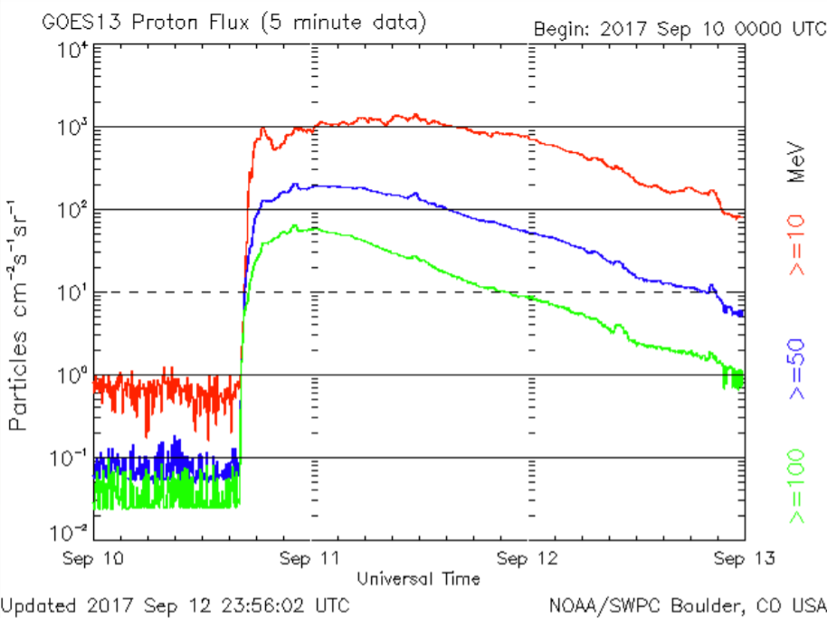

In [4]:
from IPython.display import Image
#Image(filename ='solar_flare.jpg')
Image(filename='GOES_SEP.png') 

## Split smaller dataset for flares

Since we have way too many flares we should split the training set to have fewer.

In [5]:
number_train_flares = 1500

x_train_SEPS = x_train.loc[y_train['class'] == 1] 
x_train_flares  = x_train.loc[y_train['class'] == 0] 

#Alternative way to calculate remaining flares
#x_train_rescaled_flares2 =  pd.concat([x_train_rescaled_SEPS,x_train_rescaled]).drop_duplicates(keep=False)

#undersampled_flares
x_train_undersampled_flares = x_train_flares.sample(number_train_flares,random_state=2)

#remaining flares to be added to test set
remaining_flares_x = x_train_flares.drop(x_train_undersampled_flares.index.values)
remaining_flares_and_seps_y = y_train.drop(x_train_undersampled_flares.index.values)
remaining_flares_y = remaining_flares_and_seps_y.drop(x_train_SEPS.index.values)

x_test = pd.concat([x_test,remaining_flares_x])
y_test = pd.concat([y_test,remaining_flares_y])

#y_train_rescaled_undersampled_flares = y_train_init.loc[x_train_rescaled_undersampled_flares.index.values]

# Create the new training set
x_train = pd.concat([x_train_undersampled_flares,x_train_SEPS])
y_train= y_train.loc[x_train.index.values]


y_train = keras.utils.to_categorical(y_train)
y_test = keras.utils.to_categorical(y_test)

x_train_features = x_train[columns_to_use]
x_test_features = x_test[columns_to_use]

## Example of Model Setup

Let's setup a model below

In [6]:
import NN_models_SR 
import importlib
importlib.reload(NN_models_SR)
from NN_models_SR import simple_model
from NN_models_SR import deeper_model
from tensorflow.keras.utils import to_categorical

nin = len(x_train_features.columns)


SGD_2 = tf.keras.optimizers.SGD(
    learning_rate=0.005, momentum=0.5, nesterov=True
)

optimizer_choice_1 = 'Adam'
optimizer_choice_2 = SGD_2

scaling_factor = len(y_train[y_train[:,1] ==0])/len(y_train[y_train[:,1] ==1]) # we introduce a scaling factor equal to the ratio of the classes


model_used = simple_model(nin,number_of_classes,optimizer_choice_1,scaling_factor) # the class ratio is used directly in the model (in this example is better than changing weights)

class_weight_choice = {0: 1,
                1: scaling_factor}

2023-08-21 14:19:06.277290: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-08-21 14:19:06.277365: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


## Example of Training proccedure


Let's now train our model

In [7]:
from tensorflow.keras.callbacks import EarlyStopping

batch_size_choice = round(len(x_train_features))

early_stop = EarlyStopping(monitor='loss' , min_delta=1e-04, patience=50 , verbose=1,
                                   mode ='auto', restore_best_weights= True)

history = model_used.fit(x_train_features, y_train, epochs=300, batch_size=batch_size_choice, 
                         verbose=0, 
                         callbacks=[early_stop],
                         validation_data = (x_test_features, y_test))
#class_weight=class_weight_choice,

2023-08-21 14:19:08.739620: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-21 14:19:08.803908: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp_10.
2023-08-21 14:19:09.522975: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


# Visualziating results (simple metrics)

Let's see the results

In [9]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

predictions = model_used.predict(x_test_features)
predictions_binary = np.argmax(predictions, axis = 1)
y_test_binary = np.argmax(y_test, axis=1)
    
cr = classification_report(y_test_binary, predictions_binary)
cm = confusion_matrix(y_test_binary, predictions_binary)

print(cm)
print("Class 1 accuracy")
print(cm[0,0]/(cm[0,0]+cm[0,1]))

print("Class 2 accuracy")
print(cm[1,1]/(cm[1,0]+cm[1,1]))

print(model_used.summary())
print(cr)

513/513 [==============================] - 1s 3ms/step
[[15466   909]
 [    3    20]]
Class 1 accuracy
0.9444885496183206
Class 2 accuracy
0.8695652173913043
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 40)                1280      
                                                                 
 batch_normalization (BatchN  (None, 40)               160       
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 40)                0         
                                                                 
 dense_1 (Dense)             (None, 30)                1230      
                                                                 
 re_lu_1 (ReLU)              (None, 30)                0         
                              

# Visualziating results (Plots)

Let's see the results

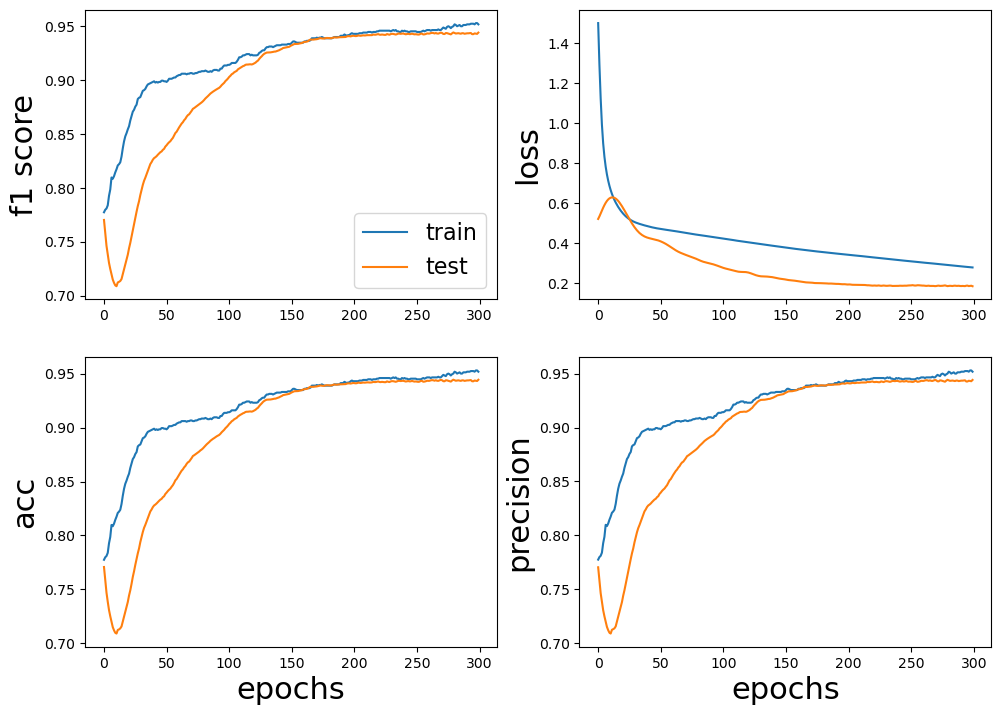

In [10]:
import matplotlib.pyplot as plt

val_f1 = history.history['val_f1_m']
val_loss= history.history['val_loss']
val_acc= history.history['val_acc']
val_prec= history.history['val_precision_m']

train_f1 = history.history['f1_m']
train_loss = history.history['loss']
train_acc = history.history['acc']
train_prec = history.history['precision_m']

plt.figure(figsize=(11.69,8.27))
plt.subplot(2, 2, 1)
plt.plot(train_f1)
plt.plot(val_f1)
plt.ylabel('f1 score',fontsize=22)
plt.legend(['train', 'test'], loc='lower right',fontsize=16)

plt.subplot(2, 2, 2)
plt.plot(train_loss)
plt.plot(val_loss)
plt.ylabel('loss',fontsize=22)

plt.subplot(2, 2, 3)
plt.plot(train_acc)
plt.plot(val_acc)
plt.xlabel('epochs',fontsize=22)
plt.ylabel('acc',fontsize=22)

plt.subplot(2, 2, 4)
plt.plot(train_prec)
plt.plot(val_prec)
plt.xlabel('epochs',fontsize=22)
plt.ylabel('precision',fontsize=22)

plt.show()

In [22]:
shap.initjs()
explainer = shap.KernelExplainer(model_used, x_test_features.iloc[:100,:])
shap_values = explainer.shap_values(x_test_features.iloc[10,:], nsamples=500)
shap.force_plot(explainer.expected_value[0], shap_values[0], x_test_features.iloc[10,:])
#plt.savefig("Example SHAP1.png",dpi=200)


In [23]:
shap_values50 = explainer.shap_values(x_test_features.iloc[10:20,:], nsamples=500)
shap.force_plot(explainer.expected_value[0], shap_values50[0], x_test_features.iloc[10:20,:])

100%|██████████| 10/10 [00:01<00:00,  5.38it/s]
